In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

To recap, variables of interest include: 

+ Echo parameters (LV systolic, RV size, pulmonary hypertension)
+ Fluids (day 1: missing term = 1 only if missing on day 1, day1-2: missing term = 1 if missing on day 1 or 2, day1-3: missing term = 1 if missing on day 1, day 2 or day 3)
+ Interactions: fluids x echo variables, fluids x CHF, echo x CHF
+ Covariates: Age, gender, BMI, BMI missing, mech vent, CHF, MDRD, Cr missing, apache score, lactate, lactate missing, ICU type, pressors indicator variable

Because of collinearity: 

+ Use only 1 fluid term per model
+ Use only 1 echo type variable per model
+ Use forward selection for interaction terms

In [5]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [6]:
len(ef)

61532

In [7]:
F = (ef['use_record'] == 1)

In [8]:
ef = ef.loc[F]
len(ef)

9320

# Preprocessing

## Calculate MDRD and add to feature table

In [9]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [10]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    2524
1    2068
2    1439
4    1280
3    1258
5     503
dtype: int64

In [11]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    4592
1    2697
2    1783
dtype: int64

## Create general features table

In [12]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [13]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

no_echo = np.isnan(ef.ea_key)
#X['no_echo'] = no_echo.astype(float)

lvsys = ef.ea_lv_systolic
lv_missing = ((np.isnan(lvsys) | (lvsys < -1)) & ~no_echo).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_mild_depressed = (lvsys == 1).astype(float)
lv_mod_depressed = (lvsys == 2).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_hyper'] = lv_hyperdynamic
X['lv_mild'] = lv_mild_depressed
X['lv_moderate'] = lv_mod_depressed
X['lv_severe'] = lv_sev_depressed

tvpulm = ef.ea_tv_pulm_htn
tv_missing = ((np.isnan(tvpulm) | (tvpulm < -2)) & ~no_echo).astype(float)
tv_normal = (tvpulm == 0).astype(float)
tv_abnormal = ((tvpulm == -2) | (tvpulm > 0)).astype(float)
X['plm_htn_missing'] = tv_missing
X['plm_htn_normal'] = tv_normal
X['plm_htn_abnormal'] = tv_abnormal

rvcavity = ef.ea_rv_cavity
rvcav_missing = ((np.isnan(rvcavity) | (rvcavity < -2)) & ~no_echo).astype(float)
rvcav_normal = (rvcavity == 0).astype(float)
rvcav_small = (rvcavity == -1).astype(float)
rvcav_dilated = ((rvcavity == -2) | (rvcavity > 0)).astype(float)
X['rvcav_missing'] = rvcav_missing
X['rvcav_normal'] = rvcav_normal
X['rvcav_small'] = rvcav_small
X['rvcav_dilated'] = rvcav_dilated

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

## which ICU was treating the patient
sicu = ef.st_sicu.astype(float)
sicu[np.isnan(sicu)] = 0
nsicu = ef.st_nsicu.astype(float)
nsicu[np.isnan(nsicu)] = 0
micu = ef.st_micu.astype(float)
micu[np.isnan(micu)] = 0
X['sicu'] = sicu
X['nsicu'] = nsicu
X['micu'] = micu

## on vasopressors
on_vaso = ef.filter_vaso.astype(float)
X['on_vaso'] = on_vaso

## fluids
fluid_day1 = ef.fb_day1_balance_ml.values
f1_missing = np.isnan(fluid_day1)
fluid_day1[~f1_missing] = normalize(fluid_day1[~f1_missing])
fluid_day1[f1_missing] = 0
X['fluid_day1'] = fluid_day1
X['fluid_day1_missing'] = f1_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
f2_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2)
fluid_day2[~f2_missing] = normalize(fluid_day2[~f2_missing])
fluid_day2[f2_missing] = 0
X['fluid_day2'] = fluid_day2
X['fluid_day2_missing'] = f2_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
f3_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2) | np.isnan(fluid_day3)
fluid_day3[~f3_missing] = normalize(fluid_day3[~f3_missing])
fluid_day3[f3_missing] = 0
X['fluid_day3'] = fluid_day3
X['fluid_day3_missing'] = f3_missing.astype(float)

y = (ef.dod - ef.intime) < np.timedelta64(30, 'D')

X.shape, y.shape

((9320, 35), (9320,))

In [14]:
echo_features = {
    'lv': ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe'], 
    'plm_htn': ['plm_htn_missing', 'plm_htn_normal', 'plm_htn_abnormal'], 
    'rvcav': ['rvcav_missing', 'rvcav_normal', 'rvcav_small', 'rvcav_dilated'], 
}
fluid_features = {
    'fluid_day1': ['fluid_day1', 'fluid_day1_missing'], 
    'fluid_day2': ['fluid_day2', 'fluid_day2_missing'], 
    'fluid_day3': ['fluid_day3', 'fluid_day3_missing'],
}
# Age, gender, BMI, BMI missing, mech vent, CHF, MDRD, Cr missing, apache score, lactate, 
#lactate missing, ICU type, pressors indicator variable
covariates = ['age', 'age_over_90', # age
    "gender", # gender
    "bmi", "bmi_missing", # bmi
    "mech_vent", # mech_vent
    "CHF", # CHF
    "mdrd", "creatinine_missing", # MDRD
    "apsiii", # apache score
    "lactate", "lactate_missing", # lactate
    "sicu", "nsicu", "micu", # icu type
    "on_vaso", # pressors indicator variable
]

Train fluid features x echo features models: 

Compare AUROC for each set. 

In [15]:
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics

In [138]:
ytr, yte = sklearn.model_selection.train_test_split(y, stratify = y)

models = {}
scores = {}
coefs = {}

Xs = {}

Xc = X[covariates]
X_ = Xc.copy()
Xtr = X_.loc[ytr.index]
Xte = X_.loc[yte.index]

model = sklearn.linear_model.LogisticRegressionCV(penalty = 'l1', solver = 'liblinear')
model.fit(Xtr, ytr)

ypr = model.predict(Xte)
score = sklearn.metrics.roc_auc_score(yte, ypr)
print('null', 'null', score)

models[('null', 'null')] = model
scores[('null', 'null')] = model
coefs[('null', 'null')] = pd.Series(model.coef_[0], index = Xtr.columns)

def make_data(fluid_fs, echo_fs): 
    
        Xf = X[fluid_features[fluid_fs]]
        Xe = X[echo_features[echo_fs]]
        Xc = X[covariates]

        # Interactions: fluids x echo variables, fluids x CHF, echo x CHF
        # Fluids x echo variables
        Xfe = {}
        for cf in Xf.columns: 
            for ce in Xe.columns: 
                Xfe["{}*{}".format(cf, ce)] = Xf[cf]*Xe[ce]
        Xfe = pd.DataFrame(Xfe)

        # Fluids x CHF
        Xfc = {}
        for cf in Xf.columns:
            Xfc["{}*CHF".format(cf)] = Xf[cf] * Xc['CHF']
        Xfc = pd.DataFrame(Xfc)

        # Echo x CHF
        Xec = {}
        for ce in Xe.columns: 
            Xec["{}*CHF".format(ce)] = Xe[ce] * Xc['CHF']
        Xec = pd.DataFrame(Xec)
        
        return pd.concat([Xf, Xe, Xc, Xfe, Xfc, Xec], axis = 1)

for fluid_fs in fluid_features.keys(): 
    for echo_fs in echo_features.keys(): 
        
        X_ = make_data(fluid_fs, echo_fs)
        Xs[(fluid_fs, echo_fs)] = X_

        Xtr = X_.loc[ytr.index]
        Xte = X_.loc[yte.index]

        model = sklearn.linear_model.LogisticRegressionCV(penalty = 'l1', solver = 'liblinear')
        model.fit(Xtr, ytr)

        ypr = model.predict(Xte)
        score = sklearn.metrics.roc_auc_score(yte, ypr)
        print(fluid_fs, echo_fs, score)
        
        models[(fluid_fs, echo_fs)] = model
        scores[(fluid_fs, echo_fs)] = score
        coefs[(fluid_fs, echo_fs)] = pd.Series(model.coef_[0], index = Xtr.columns)

null null 0.642604534579
fluid_day3 rvcav 0.642770878432
fluid_day3 lv 0.643999088527
fluid_day3 plm_htn 0.649308419733
fluid_day2 rvcav 0.647913865786
fluid_day2 lv 0.649474763587
fluid_day2 plm_htn 0.647150507007
fluid_day1 rvcav 0.643832744674
fluid_day1 lv 0.644233792868
fluid_day1 plm_htn 0.63148228324


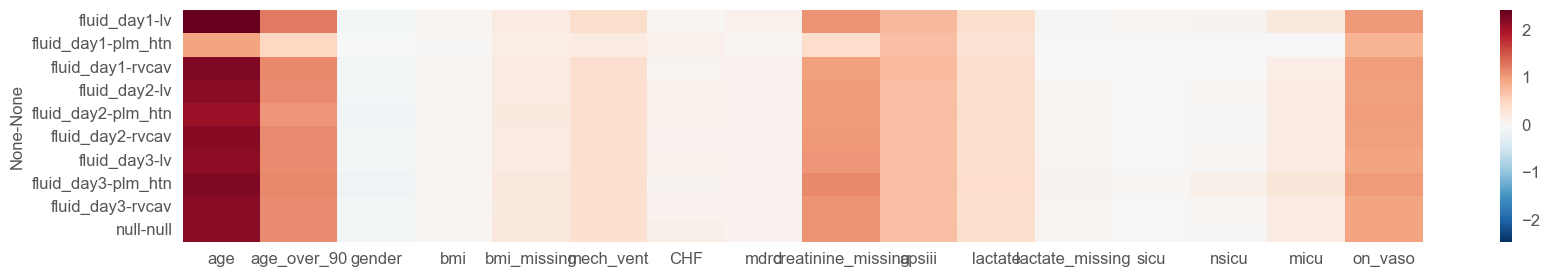

In [139]:
plt.figure(figsize = (20,3))
sns.heatmap(pd.concat(coefs).unstack()[covariates])

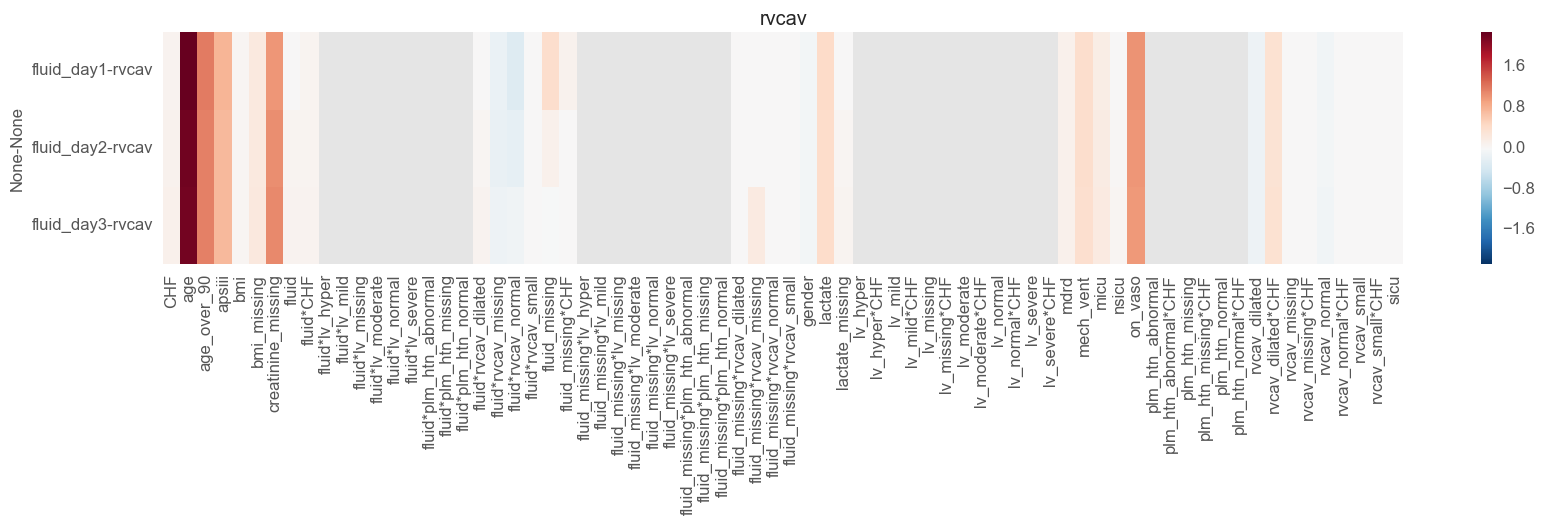

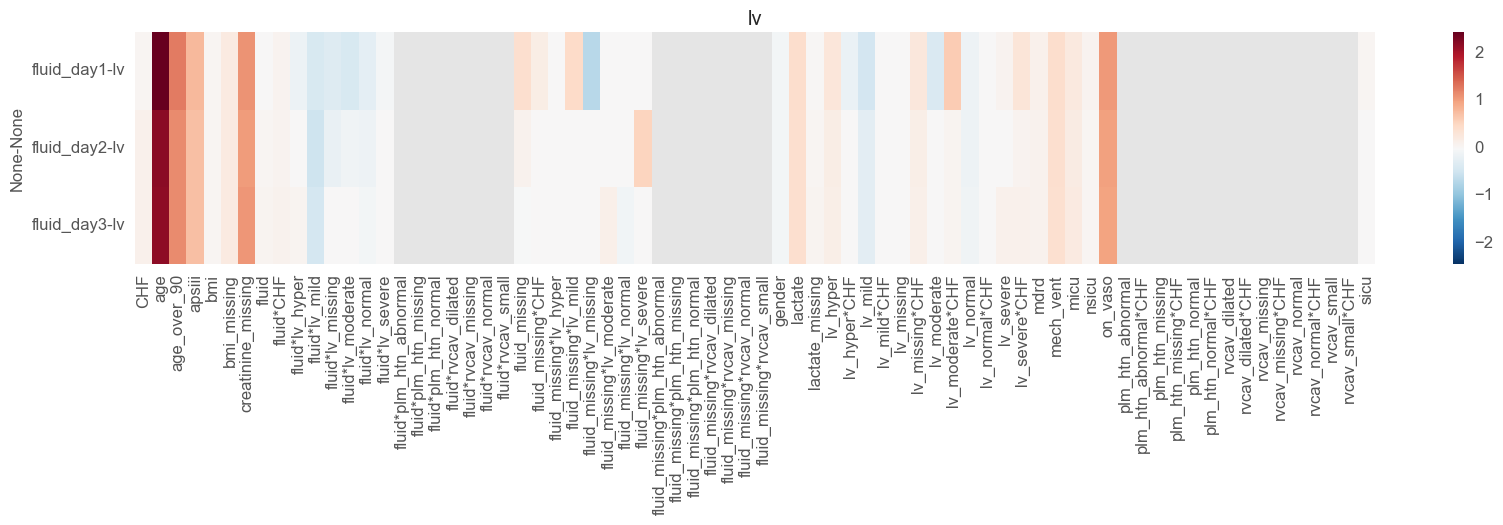

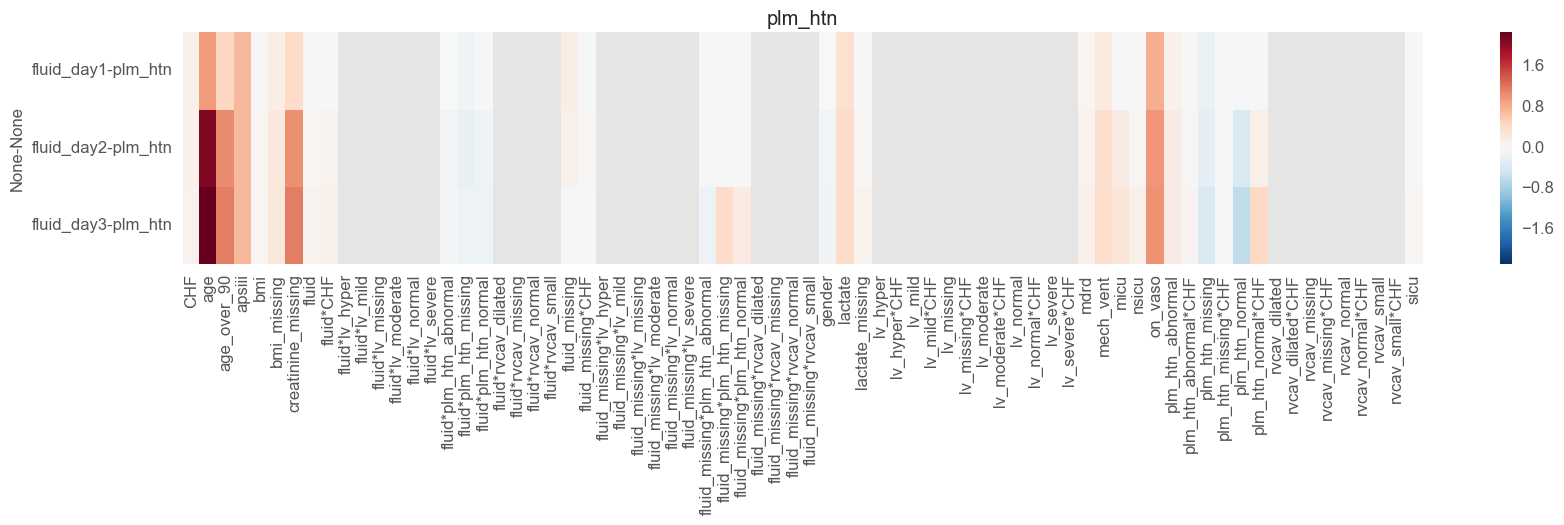

In [140]:
import copy

inspect = {}
it = copy.deepcopy(coefs)
for k, v in it.items():
    v.index = [c.replace(k[0], 'fluid') for c in v.index]
    inspect[k] = v
inspect = pd.DataFrame(inspect)

for echo_fs in echo_features.keys(): 

    to_plot = inspect.loc[:,(slice(None), echo_fs)]
    plt.figure(figsize = (20,3))
    sns.heatmap(to_plot.transpose())
    plt.title(echo_fs)

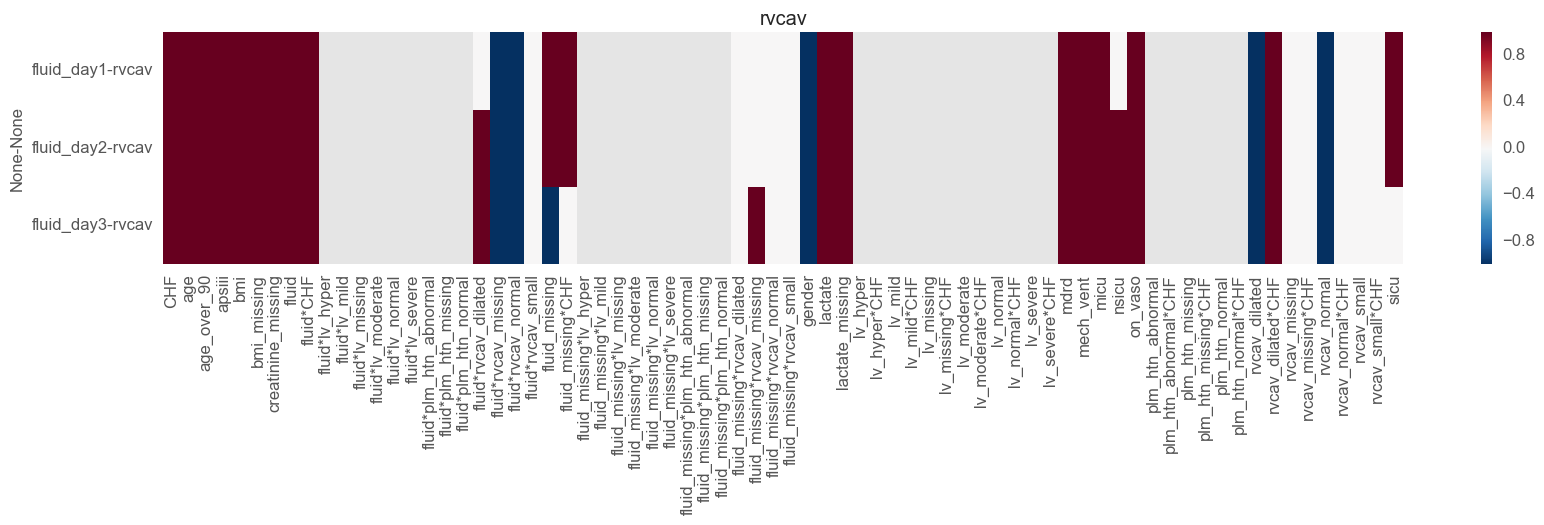

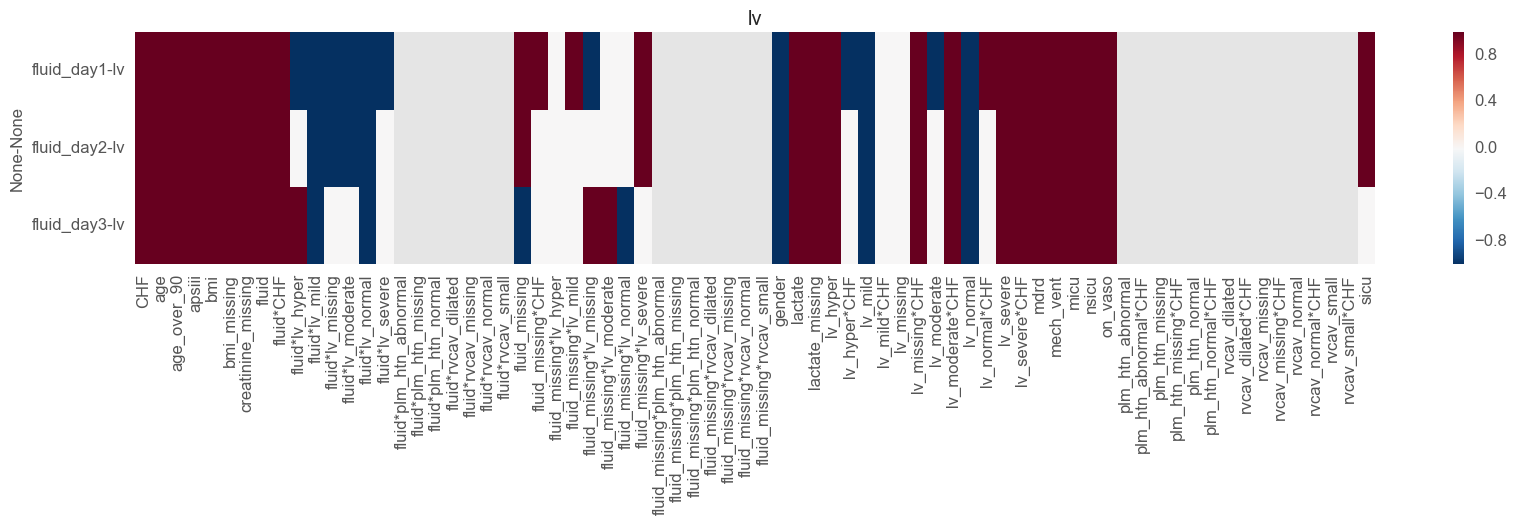

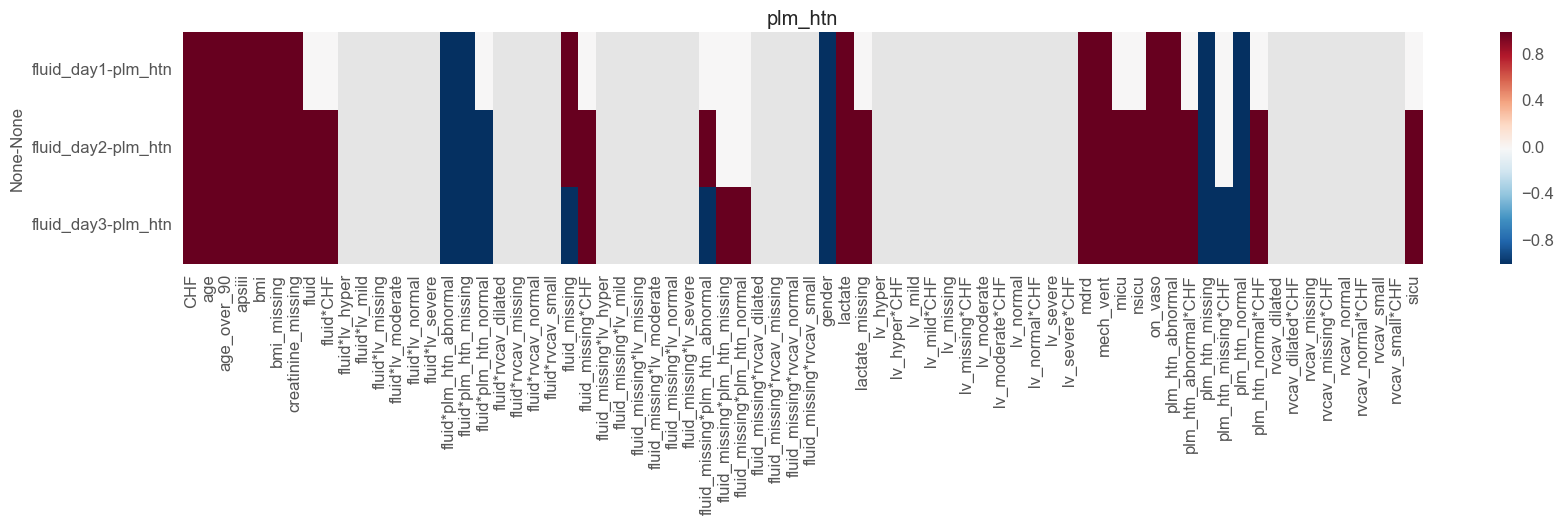

In [141]:
inspect = {}
it = copy.deepcopy(coefs)
for k, v in it.items():
    v.index = [c.replace(k[0], 'fluid') for c in v.index]
    inspect[k] = v
inspect = pd.DataFrame(inspect)

for echo_fs in echo_features.keys(): 

    to_plot = np.sign(inspect.loc[:,(slice(None), echo_fs)])
    
    plt.figure(figsize = (20,3))
    sns.heatmap(to_plot.transpose())
    plt.title(echo_fs)

In [99]:
import pymc3 as pm

In [100]:
def ridge(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [101]:
def logistic(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    yh = T.nnet.sigmoid(T.dot(X, beta) + intercept)
    ydist = pm.Bernoulli('y', yh, observed=y)

## fluid_day1 x rvcav

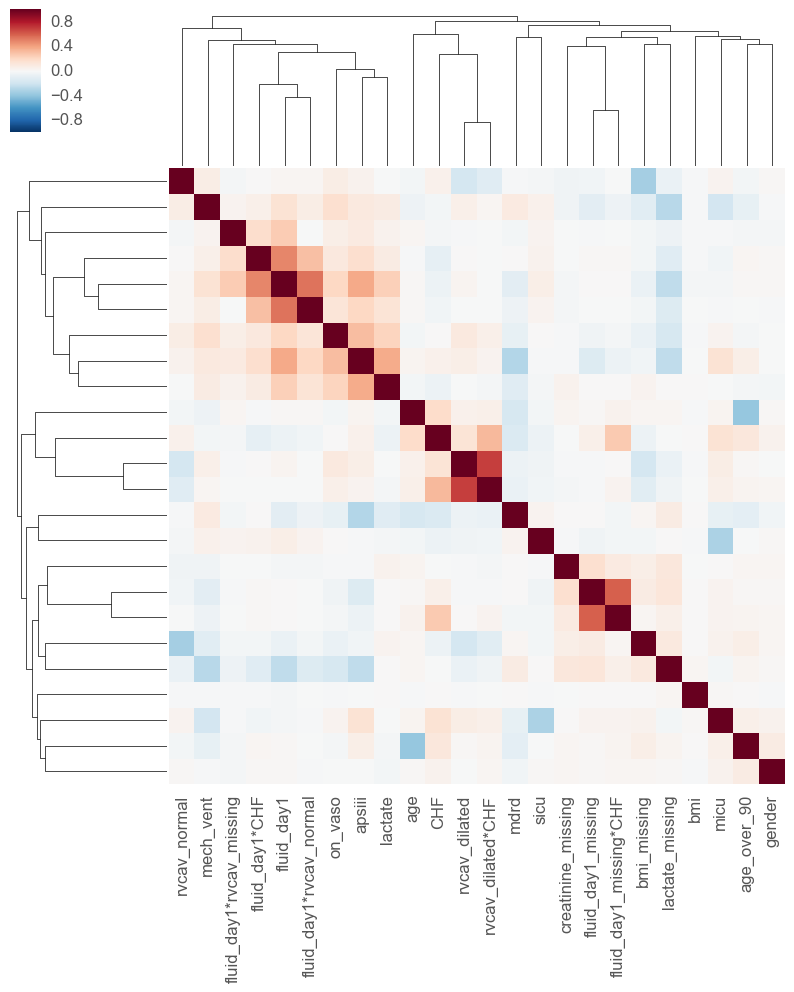

In [142]:
fluid_fs = 'fluid_day1'
echo_fs = 'rvcav'

Xb = Xs[(fluid_fs, echo_fs)].loc[:,coefs[(fluid_fs, echo_fs)].abs() > 0]
sns.clustermap(Xb.corr(), yticklabels = False)

In [143]:
with pm.Model() as model: 
    logistic(Xb, y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    trace = pm.sample(2000, step)

         Current function value: 4488.646174
         Iterations: 35
         Function evaluations: 106
         Gradient evaluations: 95


100%|██████████| 2000/2000 [05:20<00:00,  6.24it/s]


In [144]:
bayesian_coefs = pd.DataFrame(trace[200:]['beta'], columns = Xb.columns)
bayesian_coefs['intercept'] = trace[200:]['intercept']
bayesian_coefs.head()

,fluid_day1,fluid_day1_missing,rvcav_normal,rvcav_dilated,age,age_over_90,gender,bmi,bmi_missing,mech_vent,...,lactate_missing,sicu,micu,on_vaso,fluid_day1*rvcav_missing,fluid_day1*rvcav_normal,fluid_day1*CHF,fluid_day1_missing*CHF,rvcav_dilated*CHF,intercept
0,-0.030112,0.451458,-0.115278,-0.176237,2.138028,1.119737,-0.030885,0.038356,0.141293,0.300007,...,-0.010302,0.031535,0.292462,1.147990,-0.200875,-0.309808,0.153630,0.412477,0.333676,-2.369024
1,0.116791,0.372943,0.019622,0.030143,2.148316,1.208219,-0.127437,0.048155,0.357126,0.395771,...,0.132503,-0.097642,0.140955,0.935947,-0.051856,-0.327799,-0.008350,0.431369,0.419107,-2.380529
2,-0.004921,0.416843,-0.115553,-0.329404,1.997789,0.931754,-0.010061,0.044440,0.213022,0.392148,...,-0.031872,0.067202,0.322870,1.111343,-0.270354,-0.289230,0.204823,0.342956,0.574081,-2.367362
3,0.116577,0.158390,0.009459,-0.325997,2.052248,1.130343,-0.124069,0.030550,0.277752,0.460174,...,0.163150,-0.063904,0.238184,0.883557,-0.065026,-0.351554,0.035518,0.227609,0.781292,-2.410183
4,0.009785,0.133031,-0.125847,-0.335647,2.179836,1.277639,-0.022764,0.113998,0.219640,0.402516,...,0.028734,0.003718,0.348922,1.183849,-0.138655,-0.347982,0.068226,0.290831,0.557252,-2.477256


,age,age_over_90,gender,bmi,bmi_missing,mech_vent
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.345660,1.241185,-0.081802,0.062790,0.223176,0.389150
std,0.174514,0.108129,0.054956,0.031629,0.063265,0.057648
min,1.811131,0.902239,-0.250970,-0.044324,-0.010916,0.211939
25%,2.225354,1.167306,-0.120902,0.042057,0.181439,0.350555
50%,2.339682,1.241546,-0.082491,0.061996,0.221707,0.388017
75%,2.465617,1.314574,-0.045859,0.082965,0.263944,0.427038
max,2.976437,1.613219,0.074661,0.180690,0.409585,0.571908


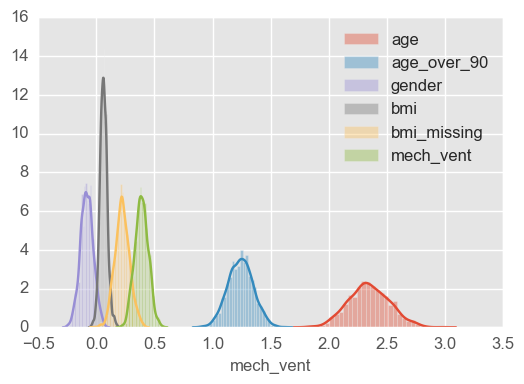

In [145]:
cols = covariates[:6]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,CHF,mdrd,creatinine_missing,apsiii,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.014631,0.114111,1.168257,0.787092,0.443094,0.049298
std,0.065790,0.026474,0.164345,0.035277,0.046311,0.061842
min,-0.270886,0.036189,0.543599,0.667225,0.299597,-0.154877
25%,-0.057285,0.096188,1.056443,0.763134,0.409959,0.008153
50%,-0.016495,0.114659,1.170994,0.787066,0.443199,0.049711
75%,0.030242,0.131437,1.278775,0.811014,0.473449,0.089063
max,0.217446,0.215128,1.689587,0.900012,0.597842,0.242346


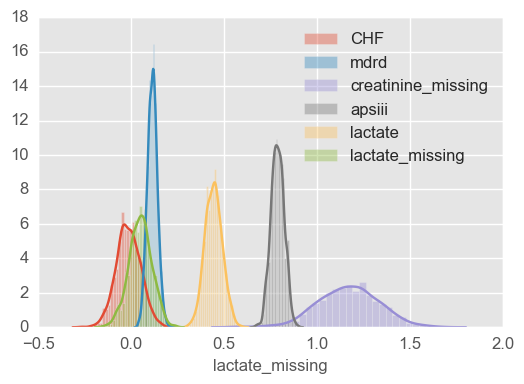

In [151]:
cols = covariates[6:12]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,sicu,nsicu,micu,on_vaso
count,1800.000000,0.0,1800.000000,1800.000000
mean,-0.017162,NaN,0.239898,1.028447
std,0.057083,NaN,0.073184,0.069975
min,-0.212624,NaN,-0.018061,0.787405
25%,-0.055686,NaN,0.193260,0.983262
50%,-0.018362,NaN,0.240773,1.030654
75%,0.022263,NaN,0.286509,1.072281
max,0.171129,NaN,0.489492,1.298835


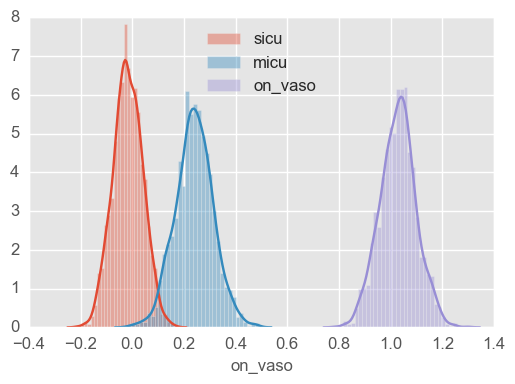

In [152]:
cols = covariates[12:]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day1,fluid_day1_missing,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated
count,1800.000000,1800.000000,0.0,1800.000000,0.0,1800.000000
mean,0.028812,0.412112,NaN,-0.062661,NaN,-0.182062
std,0.038768,0.134057,NaN,0.065110,NaN,0.142325
min,-0.077868,-0.041004,NaN,-0.248597,NaN,-0.623738
25%,0.001995,0.322975,NaN,-0.108061,NaN,-0.277260
50%,0.027361,0.417968,NaN,-0.062954,NaN,-0.183897
75%,0.056670,0.499853,NaN,-0.016382,NaN,-0.082288
max,0.177822,0.840962,NaN,0.159820,NaN,0.357453


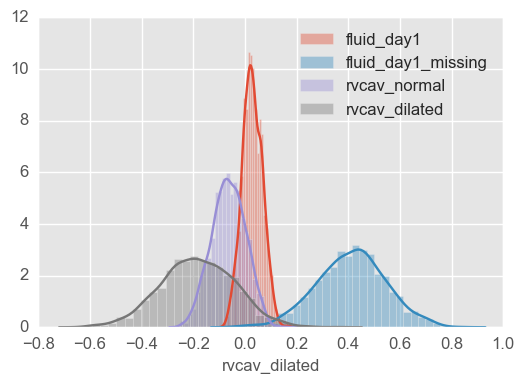

In [153]:
cols = fluid_features[fluid_fs] + echo_features[echo_fs]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day1*rvcav_missing,fluid_day1*rvcav_normal
count,1800.000000,1800.000000
mean,-0.216412,-0.330745
std,0.111892,0.059752
min,-0.592754,-0.514855
25%,-0.287912,-0.370828
50%,-0.216657,-0.331347
75%,-0.144498,-0.289514
max,0.212133,-0.137479


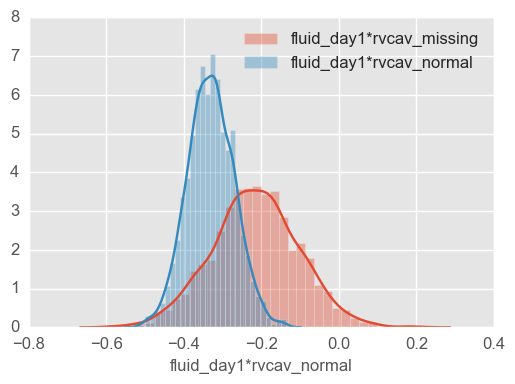

In [154]:
cols = [c for c in Xb.columns if 'fluid_day1*rvcav' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day1*CHF,fluid_day1_missing*CHF,rvcav_dilated*CHF
count,1800.000000,1800.000000,1800.000000
mean,0.094635,0.160212,0.406735
std,0.061163,0.205022,0.198326
min,-0.120942,-0.441067,-0.188727
25%,0.054046,0.019977,0.268290
50%,0.094333,0.156311,0.404572
75%,0.136109,0.303001,0.544550
max,0.323672,0.739887,1.008382


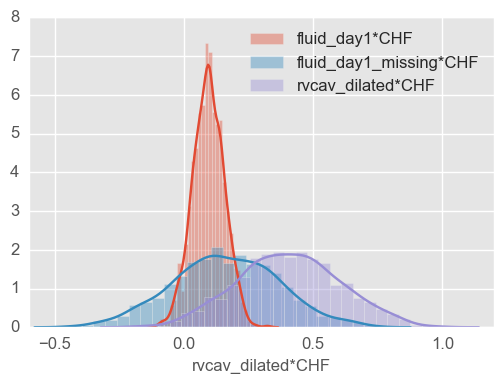

In [156]:
cols = [c for c in Xb.columns if '*CHF' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

## fluid_day3 x rvcav

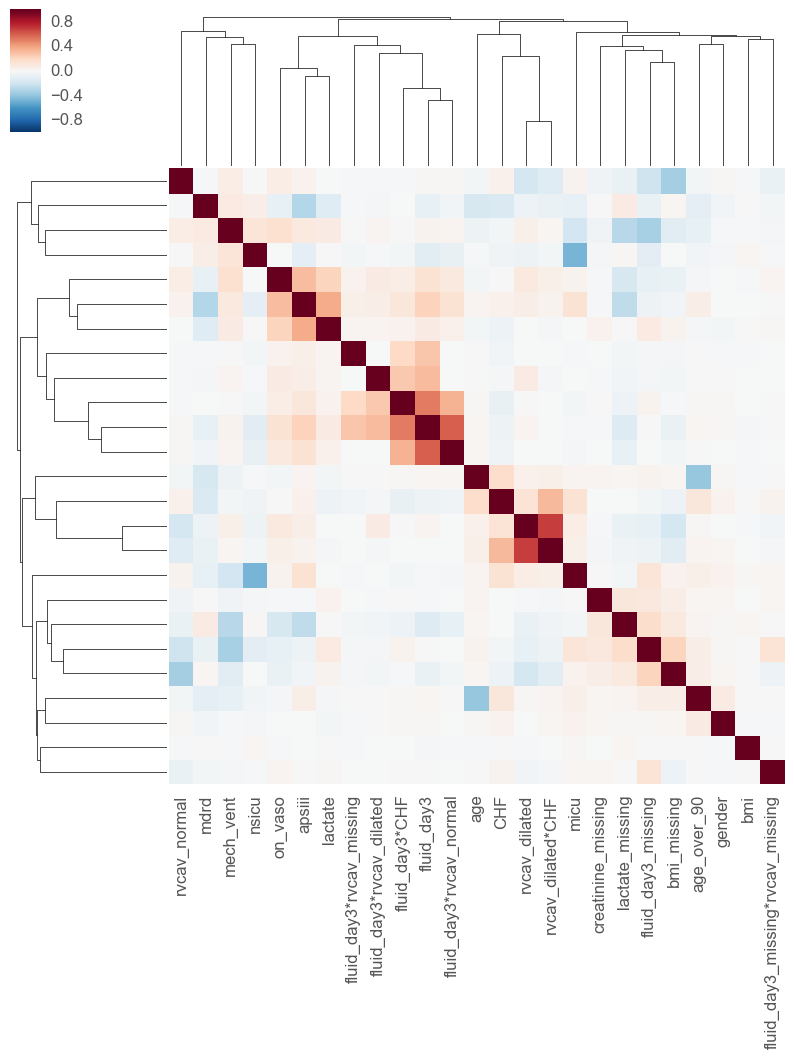

In [157]:
fluid_fs = 'fluid_day3'
echo_fs = 'rvcav'

Xb = Xs[(fluid_fs, echo_fs)].loc[:,coefs[(fluid_fs, echo_fs)].abs() > 0]
sns.clustermap(Xb.corr(), yticklabels = False)

In [158]:
with pm.Model() as model: 
    logistic(Xb, y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 4510.482787
         Iterations: 36
         Function evaluations: 45
         Gradient evaluations: 45


100%|██████████| 2000/2000 [05:22<00:00,  9.26it/s]


In [159]:
bayesian_coefs = pd.DataFrame(trace[200:]['beta'], columns = Xb.columns)
bayesian_coefs['intercept'] = trace[200:]['intercept']
bayesian_coefs.head()

,fluid_day3,fluid_day3_missing,rvcav_normal,rvcav_dilated,age,age_over_90,gender,bmi,bmi_missing,mech_vent,...,nsicu,micu,on_vaso,fluid_day3*rvcav_dilated,fluid_day3*rvcav_missing,fluid_day3*rvcav_normal,fluid_day3_missing*rvcav_missing,fluid_day3*CHF,rvcav_dilated*CHF,intercept
0,0.071070,0.069396,-0.126078,-0.194784,2.220985,1.034147,-0.056959,0.030298,0.187346,0.460375,...,0.102474,0.388339,0.935167,-0.059989,-0.139985,-0.212723,-0.024152,0.256622,0.370813,-2.466602
1,0.071070,0.069396,-0.126078,-0.194784,2.220985,1.034147,-0.056959,0.030298,0.187346,0.460375,...,0.102474,0.388339,0.935167,-0.059989,-0.139985,-0.212723,-0.024152,0.256622,0.370813,-2.466602
2,0.103403,-0.054830,-0.176082,-0.211573,2.261439,1.187808,-0.104439,0.094745,0.227660,0.370403,...,0.175830,0.428344,0.895687,0.036900,-0.047786,-0.189943,-0.070293,0.188800,0.373689,-2.422841
3,0.120471,-0.013651,-0.092887,-0.331314,2.216400,1.236081,-0.064965,0.025385,0.221279,0.438542,...,0.126827,0.269416,0.974736,0.077025,-0.098710,-0.311192,0.032150,0.245072,0.514460,-2.437794
4,0.084578,0.017440,-0.134708,-0.322690,2.283716,1.269181,-0.128213,0.045906,0.224596,0.395970,...,0.014629,0.377500,1.044502,0.072327,-0.250682,-0.039475,-0.128675,-0.036015,0.331523,-2.468481


,age,age_over_90,gender,bmi,bmi_missing,mech_vent
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.277658,1.215860,-0.080792,0.061090,0.256233,0.367686
std,0.173163,0.111082,0.052313,0.030101,0.062646,0.058479
min,1.565111,0.829238,-0.268120,-0.045567,0.020800,0.177825
25%,2.163591,1.142035,-0.116794,0.041644,0.215375,0.327730
50%,2.279732,1.220180,-0.080362,0.059376,0.255657,0.369303
75%,2.397081,1.292111,-0.045888,0.078881,0.297080,0.407680
max,2.812810,1.601229,0.073424,0.205965,0.455568,0.568699


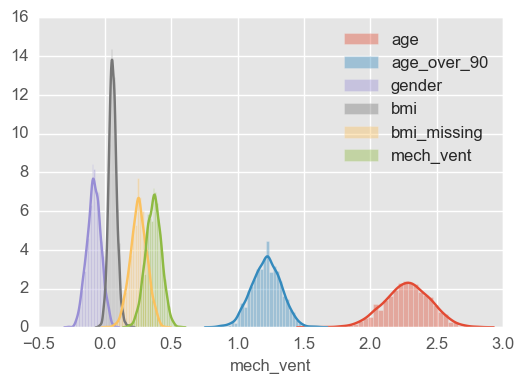

In [160]:
cols = covariates[:6]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,CHF,mdrd,creatinine_missing,apsiii,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.030116,0.114426,1.266674,0.740091,0.433791,0.092619
std,0.064219,0.027988,0.157472,0.032987,0.047443,0.059526
min,-0.170665,0.022747,0.660890,0.642073,0.275202,-0.132971
25%,-0.011957,0.095326,1.165494,0.717540,0.402110,0.052302
50%,0.030105,0.114487,1.269956,0.737859,0.433592,0.093685
75%,0.073492,0.133542,1.366150,0.761224,0.464629,0.132473
max,0.219575,0.206639,1.866497,0.851451,0.604584,0.324778


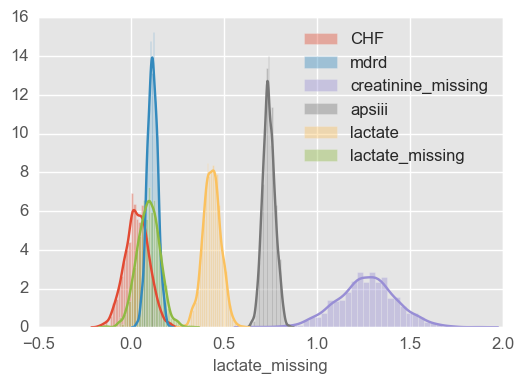

In [161]:
cols = covariates[6:12]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,sicu,nsicu,micu,on_vaso
count,0.0,1800.000000,1800.000000,1800.000000
mean,NaN,0.089105,0.296588,0.989381
std,NaN,0.103143,0.077715,0.066253
min,NaN,-0.268286,0.052221,0.740666
25%,NaN,0.018252,0.246155,0.945315
50%,NaN,0.088575,0.296860,0.989348
75%,NaN,0.157579,0.348713,1.035756
max,NaN,0.412338,0.578514,1.234961


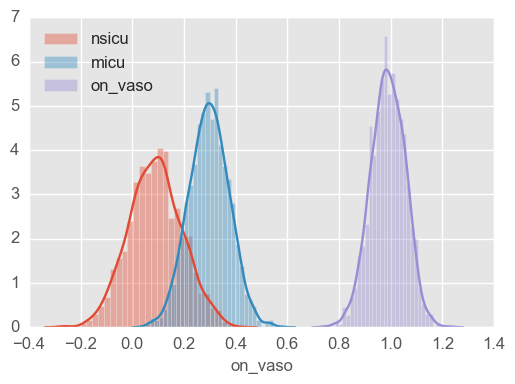

In [162]:
cols = covariates[12:]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day3,fluid_day3_missing,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated
count,1800.000000,1800.000000,0.0,1800.000000,0.0,1800.000000
mean,0.119087,-0.006957,NaN,-0.053729,NaN,-0.145542
std,0.055178,0.059109,NaN,0.066577,NaN,0.142556
min,-0.073746,-0.204086,NaN,-0.281852,NaN,-0.641980
25%,0.079136,-0.046869,NaN,-0.098348,NaN,-0.244485
50%,0.119685,-0.006802,NaN,-0.055383,NaN,-0.147480
75%,0.159868,0.032473,NaN,-0.008442,NaN,-0.049123
max,0.273758,0.188904,NaN,0.145353,NaN,0.299510


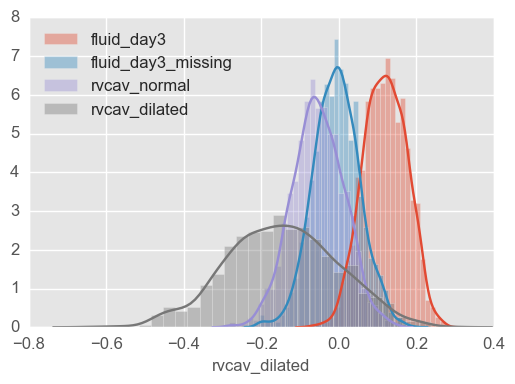

In [163]:
cols = fluid_features[fluid_fs] + echo_features[echo_fs]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day3*rvcav_dilated,fluid_day3*rvcav_missing,fluid_day3*rvcav_normal
count,1800.000000,1800.000000,1800.000000
mean,0.012977,-0.161906,-0.166588
std,0.119687,0.126235,0.074597
min,-0.450347,-0.701848,-0.387099
25%,-0.065036,-0.250436,-0.218148
50%,0.013827,-0.164372,-0.166517
75%,0.094752,-0.077429,-0.117992
max,0.383376,0.276109,0.073041


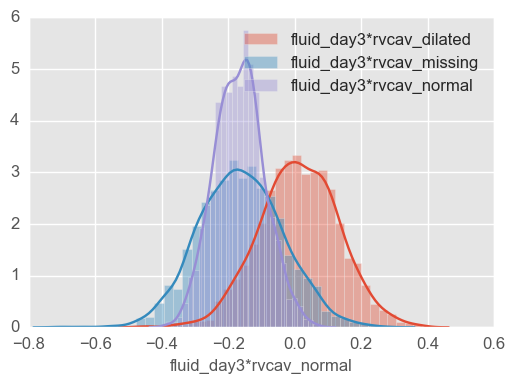

In [165]:
cols = [c for c in Xb.columns if 'fluid_day3*rvcav' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day3*CHF,rvcav_dilated*CHF
count,1800.000000,1800.000000
mean,0.104388,0.369538
std,0.079984,0.184766
min,-0.146456,-0.303179
25%,0.050546,0.251042
50%,0.105396,0.372876
75%,0.157403,0.496658
max,0.410155,0.969819


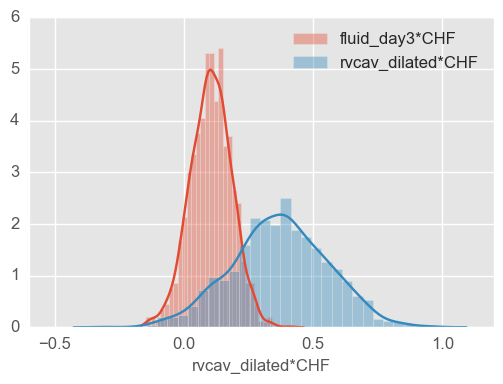

In [164]:
cols = [c for c in Xb.columns if '*CHF' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

## fluid_day2 x lv

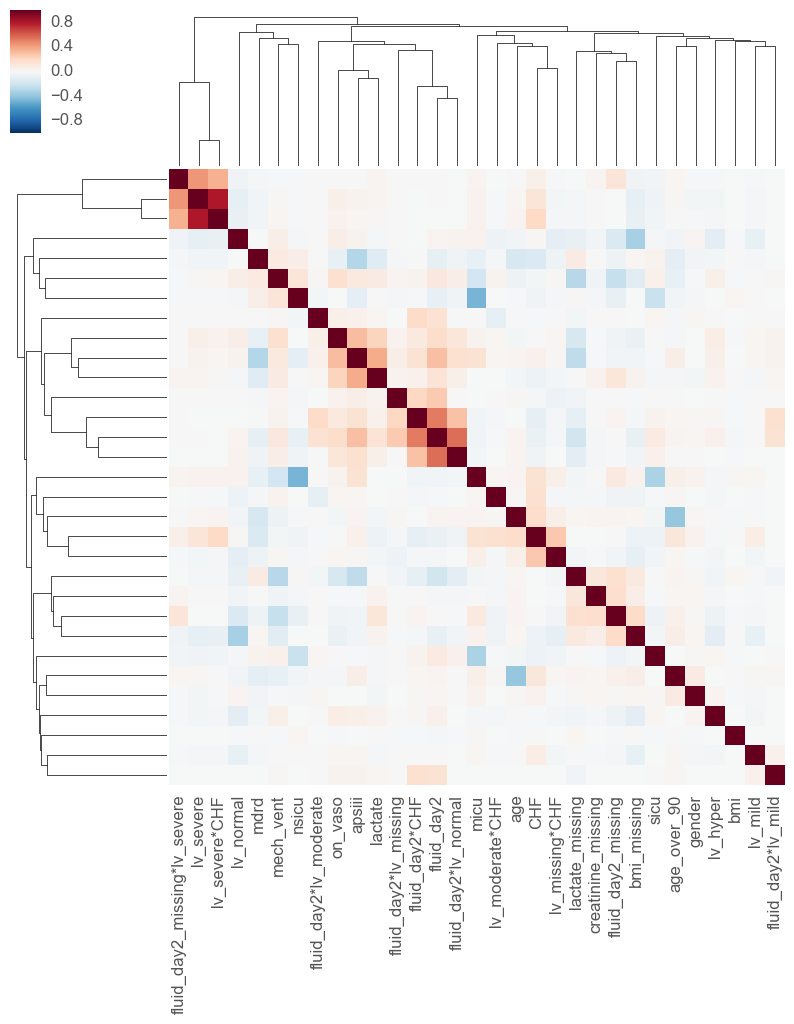

In [166]:
fluid_fs = 'fluid_day2'
echo_fs = 'lv'

Xb = Xs[(fluid_fs, echo_fs)].loc[:,coefs[(fluid_fs, echo_fs)].abs() > 0]
sns.clustermap(Xb.corr(), yticklabels = False)

In [167]:
with pm.Model() as model: 
    logistic(Xb, y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 4503.262769
         Iterations: 42
         Function evaluations: 54
         Gradient evaluations: 54


100%|██████████| 2000/2000 [10:28<00:00,  5.26it/s]


In [168]:
bayesian_coefs = pd.DataFrame(trace[200:]['beta'], columns = Xb.columns)
bayesian_coefs['intercept'] = trace[200:]['intercept']
bayesian_coefs.head()

,fluid_day2,fluid_day2_missing,lv_normal,lv_hyper,lv_mild,lv_severe,age,age_over_90,gender,bmi,...,fluid_day2*lv_mild,fluid_day2*lv_missing,fluid_day2*lv_moderate,fluid_day2*lv_normal,fluid_day2_missing*lv_severe,fluid_day2*CHF,lv_missing*CHF,lv_moderate*CHF,lv_severe*CHF,intercept
0,0.104668,0.237644,-0.104476,0.233784,-0.299182,-0.661326,2.333532,1.183657,-0.108794,0.053132,...,-0.490327,-0.583857,-0.058010,-0.298375,0.474725,0.098333,0.340645,-0.345255,0.540943,-2.477878
1,0.067202,0.208986,-0.063414,0.341630,-0.314679,-0.513029,2.430502,1.183038,-0.082862,0.069948,...,-0.383365,-0.455662,-0.092319,-0.290712,0.497436,0.264455,0.360524,-0.451505,0.537064,-2.503313
2,0.119089,0.049929,-0.077126,0.174841,-0.105193,-0.072461,2.205494,1.121319,-0.025504,0.065265,...,-0.929862,-0.520666,-0.179395,-0.153755,0.361784,0.132714,-0.009091,0.444804,0.308964,-2.498971
3,0.026807,0.111716,-0.122686,0.443207,-0.375859,-0.373148,2.618705,1.366962,-0.088849,0.092533,...,-0.612034,-0.033565,-0.039011,-0.033205,0.474776,0.083009,0.515949,0.263249,0.474742,-2.578155
4,0.058759,0.239479,0.070265,0.450694,-0.179030,-0.110595,2.576062,1.343483,-0.095737,0.087813,...,-0.740492,-0.209208,0.079534,-0.332764,0.822532,0.151540,0.326055,0.420167,0.595256,-2.565992


,age,age_over_90,gender,bmi,bmi_missing,mech_vent
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.282378,1.208210,-0.077177,0.062939,0.250766,0.383470
std,0.176098,0.106710,0.053771,0.029424,0.062269,0.057044
min,1.690189,0.751116,-0.217097,-0.026611,0.057034,0.163709
25%,2.160580,1.140453,-0.115479,0.043728,0.209989,0.344701
50%,2.282873,1.204484,-0.078623,0.063334,0.251378,0.383697
75%,2.399171,1.281155,-0.037390,0.081727,0.290498,0.422886
max,2.773410,1.580082,0.099436,0.173153,0.470739,0.596938


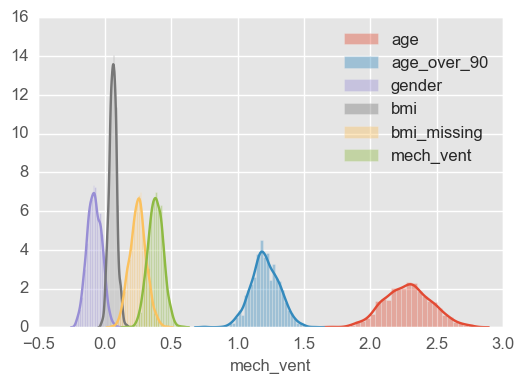

In [169]:
cols = covariates[:6]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,CHF,mdrd,creatinine_missing,apsiii,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.028909,0.113057,1.208998,0.753729,0.424765,0.072248
std,0.064682,0.027083,0.155072,0.033496,0.045494,0.057185
min,-0.183574,0.025578,0.721988,0.646465,0.289905,-0.117094
25%,-0.015914,0.094817,1.108123,0.730659,0.394569,0.033597
50%,0.027749,0.114434,1.208278,0.752332,0.424530,0.072529
75%,0.070476,0.131316,1.309832,0.777390,0.454082,0.112364
max,0.280123,0.207572,1.825468,0.862725,0.605905,0.259452


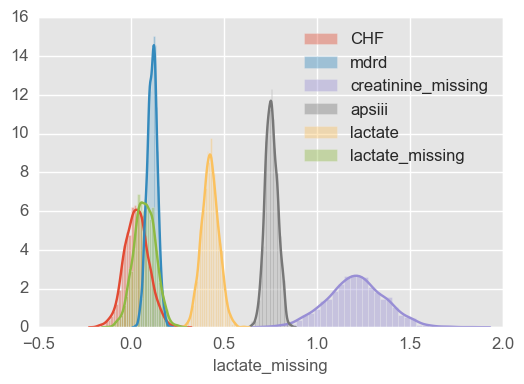

In [170]:
cols = covariates[6:12]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,sicu,nsicu,micu,on_vaso
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.010504,0.064521,0.267860,1.010710
std,0.062158,0.118338,0.086933,0.070916
min,-0.233124,-0.325932,0.008565,0.785809
25%,-0.052568,-0.016520,0.209441,0.963724
50%,-0.011304,0.064611,0.265336,1.010751
75%,0.032576,0.141804,0.326809,1.056541
max,0.182915,0.468428,0.608476,1.259189


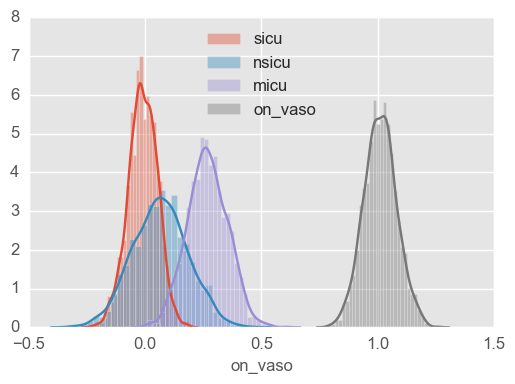

In [171]:
cols = covariates[12:]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day2,fluid_day2_missing,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,0.0,1800.000000,1800.000000,1800.000000,0.0,1800.000000
mean,0.066768,0.154379,NaN,-0.054193,0.307369,-0.212139,NaN,-0.132379
std,0.044623,0.071588,NaN,0.066420,0.137237,0.188158,NaN,0.261376
min,-0.060587,-0.088878,NaN,-0.303921,-0.209794,-0.871886,NaN,-0.995015
25%,0.035740,0.105447,NaN,-0.098339,0.221003,-0.330906,NaN,-0.300726
50%,0.065315,0.155436,NaN,-0.054505,0.307576,-0.214028,NaN,-0.124351
75%,0.098094,0.204648,NaN,-0.012554,0.394494,-0.092345,NaN,0.052606
max,0.225632,0.386955,NaN,0.186776,0.734679,0.334039,NaN,0.650840


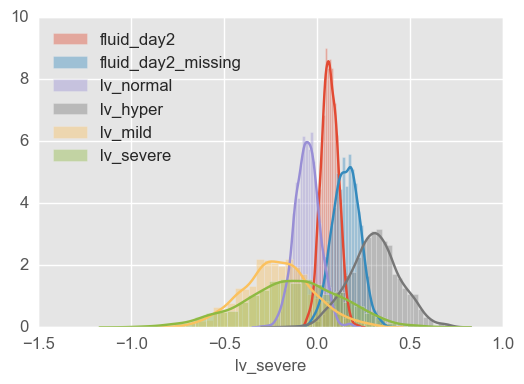

In [172]:
cols = fluid_features[fluid_fs] + echo_features[echo_fs]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day2*lv_mild,fluid_day2*lv_missing,fluid_day2*lv_moderate,fluid_day2*lv_normal
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.647641,-0.198460,-0.130130,-0.202260
std,0.188768,0.109705,0.192517,0.066785
min,-1.359889,-0.644860,-0.709864,-0.409761
25%,-0.767458,-0.271414,-0.260378,-0.247526
50%,-0.643605,-0.198677,-0.134825,-0.201992
75%,-0.527024,-0.123198,-0.006842,-0.157135
max,0.014487,0.096561,0.640196,0.030061


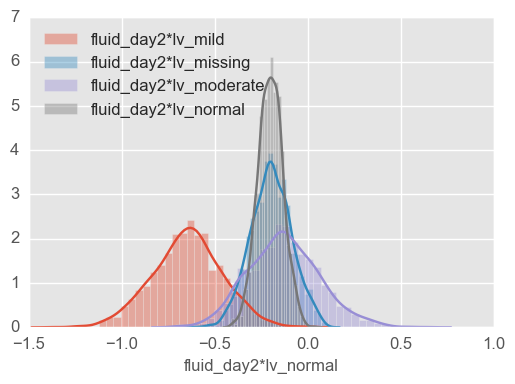

In [175]:
cols = [c for c in Xb.columns if 'fluid_day2*lv' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')

,fluid_day2*CHF,lv_missing*CHF,lv_moderate*CHF,lv_severe*CHF
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.126577,0.251659,0.170362,0.173461
std,0.066710,0.151858,0.254588,0.310713
min,-0.059594,-0.279054,-0.725985,-0.809927
25%,0.083256,0.141564,0.005606,-0.031467
50%,0.126190,0.253717,0.174473,0.172463
75%,0.169707,0.352506,0.344739,0.375712
max,0.336157,0.785273,0.917571,1.182446


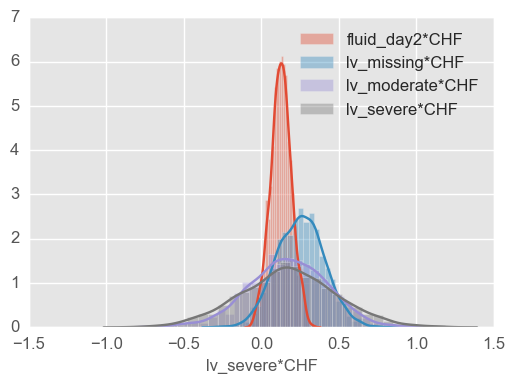

In [176]:
cols = [c for c in Xb.columns if '*CHF' in c]
display(bayesian_coefs.loc[:,cols].describe())
for c in cols: 
    if c not in bayesian_coefs.columns:
        continue
    sns.distplot(bayesian_coefs[c], label = c)
_ = plt.legend(loc = 'best')